In [1]:
import os
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

# Reading Data using Pandas and SQLite3

In [2]:
# helper function to join tables across different database (.db) files
def join_tables(tables):
    
    df = tables[0]
    for table in tables[1:]:
        df = pd.concat([df, table])
        
    return df.reset_index(drop=True)

# joining all database (.db) files of folder
def get_all_databases(folder):
    
    string_tables = []
    ull_tables = []
    files = os.listdir(folder)
    
    # iterating through all files of folder to append tables
    for file in files:
        path = os.path.join(folder, file)
        con = sqlite3.connect(path)
        string_tables.append(pd.read_sql_query('SELECT COUNTERS_STRING_TIME_DATA.*, INPUTS.INPUT_DESCRIPTION FROM COUNTERS_STRING_TIME_DATA LEFT JOIN INPUTS WHERE COUNTERS_STRING_TIME_DATA.ID_INPUT == INPUTS.ID_INPUT', con))
        ull_tables.append(pd.read_sql_query('SELECT COUNTERS_ULL_TIME_DATA.*, INPUTS.INPUT_DESCRIPTION FROM COUNTERS_ULL_TIME_DATA LEFT JOIN INPUTS WHERE COUNTERS_ULL_TIME_DATA.ID_INPUT == INPUTS.ID_INPUT', con))
        
    # concatenating tables into single DataFrames
    string_df = join_tables(string_tables)
    string_df.loc[:, 'VALUE'] = string_df.loc[:, 'VALUE'].replace({'WWAHost.exe': 'Netflix.exe'}) 
    string_df.loc[:, 'VALUE'] = string_df.loc[:, 'VALUE'].str.lower()
    string_df.loc[string_df['INPUT_DESCRIPTION'] == 'Mouse cursor icon state.', 'ID_INPUT'] = 2
    string_df.loc[string_df['INPUT_DESCRIPTION'] == 'Foreground window .exe process.', 'ID_INPUT'] = 3
    ull_df = join_tables(ull_tables)
    ull_df.loc[ull_df['INPUT_DESCRIPTION'] == 'Mouse X position in pixel(s)', 'ID_INPUT'] = 0
    ull_df.loc[ull_df['INPUT_DESCRIPTION'] == 'Mouse Y position in pixel(s)', 'ID_INPUT'] = 1
    ull_df.loc[ull_df['INPUT_DESCRIPTION'] == 'Foreground window is immersive.', 'ID_INPUT'] = 4
    ull_df.loc[ull_df['INPUT_DESCRIPTION'] == 'Foreground window is hung.', 'ID_INPUT'] = 5
    return (string_df.drop('INPUT_DESCRIPTION', axis=1), ull_df.drop('INPUT_DESCRIPTION', axis=1))

# Problem 2
Predict the total time an application is used in the foreground.

### Problem 2a

In [66]:
string_df_0, ull_df_0 = get_all_databases('group3_collected_data')
string_df_1, ull_df_1 = get_all_databases('group3_collected_data_pc_1')

string_df_0['MEASUREMENT_TIME'] = string_df_0['MEASUREMENT_TIME'].apply(lambda x: pd.to_datetime(x).date())
foreground_0 = string_df_0[string_df_0['ID_INPUT'] == 3].groupby('MEASUREMENT_TIME').agg('count')['VALUE']

string_df_1['MEASUREMENT_TIME'] = string_df_1['MEASUREMENT_TIME'].apply(lambda x: pd.to_datetime(x).date())
foreground_1 = string_df_1[string_df_1['ID_INPUT'] == 3].groupby('MEASUREMENT_TIME').agg('count')['VALUE']

C:\Users\jared\AppData\Local\Temp/ipykernel_14716/3841127067.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(labels=['2021-11-15','2021-12-01','2021-12-15','2022-01-01','2022-01-15','2022-02-01','2022-02-15'], rotation=45);
C:\Users\jared\AppData\Local\Temp/ipykernel_14716/3841127067.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels=['2021-11-15','2021-12-01','2021-12-15','2022-01-01','2022-01-15','2022-02-01','2022-02-15'], rotation=45);


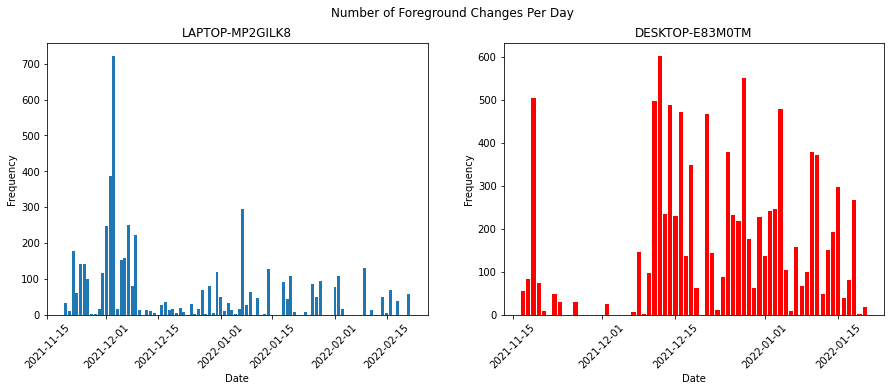

In [80]:
# plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Number of Foreground Changes Per Day')

ax1.bar(x=foreground_0.index, height=foreground_0.values)
# ax1.tick_params(rotation=45);
ax1.set_title('LAPTOP-MP2GILK8');
ax1.set_xticklabels(labels=['2021-11-15','2021-12-01','2021-12-15','2022-01-01','2022-01-15','2022-02-01','2022-02-15'], rotation=45);
ax1.set(xlabel='Date', ylabel='Frequency');

ax2.bar(x=foreground_1.index, height=foreground_1.values, color='red')
# ax2.tick_params(rotation=45);
ax2.set_title('DESKTOP-E83M0TM');
ax2.set_xticklabels(labels=['2021-11-15','2021-12-01','2021-12-15','2022-01-01','2022-01-15','2022-02-01','2022-02-15'], rotation=45);
ax2.set(xlabel='Date', ylabel='Frequency');

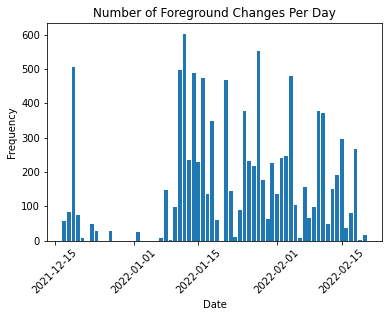

In [65]:
string_df_0, ull_df_0 = get_all_databases('group3_collected_data_pc_1')

string_df_0['MEASUREMENT_TIME'] = string_df_0['MEASUREMENT_TIME'].apply(lambda x: pd.to_datetime(x).date())
foreground_0 = string_df_0[string_df_0['ID_INPUT'] == 3].groupby('MEASUREMENT_TIME').agg('count')['VALUE']
# plt.figure(figsize=(30,5))
plt.bar(x=foreground_0.index, height=foreground_0.values)
# plt.xticks(ticks=foreground_0.index, rotation=90, fontsize=8);
plt.xticks(rotation=45);
plt.title('Number of Foreground Changes Per Day');
plt.xlabel('Date');
plt.ylabel('Frequency');

In [4]:
string_df_0[string_df_0['ID_INPUT'] == 3]['VALUE'].value_counts()

chrome.exe                2816
explorer.exe              1949
cmd.exe                    749
discord.exe                692
spotify.exe                519
                          ... 
vpnui.exe                    1
easeofaccessdialog.exe       1
streaming_client.exe         1
_conda.exe                   1
docker desktop.exe           1
Name: VALUE, Length: 65, dtype: int64

In [54]:
# getting string and ull data
string_df_0, ull_df_0 = get_all_databases('group3_collected_data')

# getting only chrome.exe data instances from string_df_0
df_0 = string_df_0[string_df_0['ID_INPUT'] == 3].drop(['ID_INPUT', 'PRIVATE_DATA'], axis=1).reset_index(drop=True)
df_0 = df_0[df_0['VALUE'] == 'chrome.exe'].reset_index(drop=True)

# converting 'MEASUREMENT_TIME' column to datetime
df_0.loc[:, 'MEASUREMENT_TIME'] = pd.to_datetime(df_0['MEASUREMENT_TIME'])

# # getting values only between '2021-11-20' and '2021-12-10'
df_0 = df_0[(df_0['MEASUREMENT_TIME'] >= pd.to_datetime('2021-11-20')) & (df_0['MEASUREMENT_TIME'] <= pd.to_datetime('2021-12-10'))].reset_index(drop=True)
# df_0 = df_0[df_0['MEASUREMENT_TIME'] >= pd.to_datetime('2022-01-07')].reset_index(drop=True)

# using converted datetime column to get usage per application ('TIME_DELTA')
time_delta = (df_0['MEASUREMENT_TIME'].shift(periods=-1) - df_0['MEASUREMENT_TIME']).drop(len(df_0)-1).apply(lambda x: float(x.total_seconds() / 60))
time_delta = time_delta.append(pd.Series(-1), ignore_index=True)

# getting usage per future application ('TIME_DELTA_1')
time_delta_1 = time_delta.shift(-1)

# adding 'TIME_DELTA' and 'TIME_DELTA_1' to DataFrame, dropping last instances with no values, and converting outliers (large numbers) to 60 minute values
df_0 = df_0.assign(**{'TIME_DELTA': time_delta, 'TIME_DELTA_1': time_delta_1})
df_0 = df_0.drop([len(df_0)-2, len(df_0)-1]).drop(['MEASUREMENT_TIME', 'VALUE'], axis=1)
df_0 = df_0.applymap(lambda x: 30 if x > 30 else x)
# df_0['TIME_DELTA'].head(10)
# df_0

In [55]:
df_0[df_0['TIME_DELTA'] < 60]

,TIME_DELTA,TIME_DELTA_1
0,0.476333,9.827483
1,9.827483,12.682167
2,12.682167,30.000000
3,30.000000,12.485400
4,12.485400,0.988900
...,...,...
783,3.684417,2.942617
784,2.942617,4.231000
785,4.231000,0.610367
786,0.610367,8.196017


In [56]:
2978 / 3029

0.9831627599867944

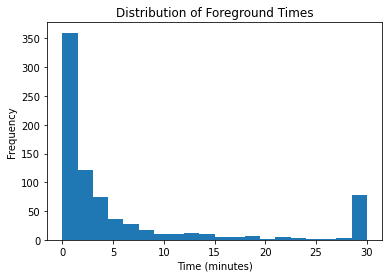

In [57]:
plt.hist(x=df_0['TIME_DELTA'], bins=20);
plt.title('Distribution of Foreground Times');
plt.xlabel('Time (minutes)');
plt.ylabel('Frequency');

Epoch 1/10
36/36 [==============================] - 2s 11ms/step - loss: 0.6669 - val_loss: 0.6910
Epoch 2/10
36/36 [==============================] - 0s 4ms/step - loss: 0.5798 - val_loss: 0.6650
Epoch 3/10
36/36 [==============================] - 0s 4ms/step - loss: 0.5639 - val_loss: 0.6646
Epoch 4/10
36/36 [==============================] - 0s 4ms/step - loss: 0.5683 - val_loss: 0.6667
Epoch 5/10
36/36 [==============================] - 0s 4ms/step - loss: 0.5616 - val_loss: 0.6648
Epoch 6/10
36/36 [==============================] - 0s 4ms/step - loss: 0.5680 - val_loss: 0.6652
Epoch 7/10
36/36 [==============================] - 0s 4ms/step - loss: 0.5676 - val_loss: 0.6654
Epoch 8/10
36/36 [==============================] - 0s 4ms/step - loss: 0.5682 - val_loss: 0.6658
Epoch 9/10
36/36 [==============================] - 0s 4ms/step - loss: 0.5649 - val_loss: 0.6649
Epoch 10/10
36/36 [==============================] - 0s 4ms/step - loss: 0.5669 - val_loss: 0.6655


,t_0,t_1,t_2,t_3,t_4
0,0.213983,2.172317,5.635950,1.315450,0.676867
1,2.172317,5.635950,1.315450,0.676867,0.210483
2,5.635950,1.315450,0.676867,0.210483,30.000000
3,1.315450,0.676867,0.210483,30.000000,4.052383
4,0.676867,0.210483,30.000000,4.052383,0.787367
...,...,...,...,...,...
148,0.450883,0.090150,2.076900,1.086833,0.817767
149,0.090150,2.076900,1.086833,0.817767,3.684417
150,2.076900,1.086833,0.817767,3.684417,2.942617
151,1.086833,0.817767,3.684417,2.942617,4.231000


,y_test,y_pred
0,0.210483,1.605652
1,30.000000,1.794927
2,4.052383,1.962914
3,0.787367,1.644083
4,2.919383,1.796612
...,...,...
148,3.684417,0.978800
149,2.942617,1.188516
150,4.231000,1.520774
151,0.610367,1.655503


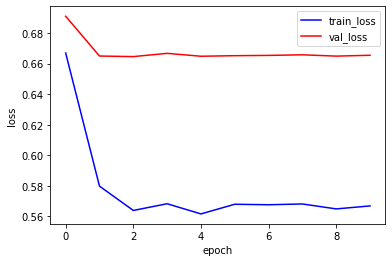

In [58]:
# importing necessary libraries
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

# defining training and testing sizes
test_size = 0.2
train_size = 1 - test_size
n_test = int(np.ceil(len(df_0) * test_size))
n_train = int(np.floor(len(df_0) * train_size))
train = df_0.loc[:n_train, ['TIME_DELTA', 'TIME_DELTA_1']].to_numpy().reshape(-1,2)
test = df_0.loc[n_train:, ['TIME_DELTA', 'TIME_DELTA_1']].to_numpy().reshape(-1,2)

# fitting scaler with training set
scaler = StandardScaler()
scaler.fit(train[:, 0].reshape(-1,1))
train = scaler.transform(train[:, 0].reshape(-1,1))
test = scaler.transform(test[:, 0].reshape(-1,1))
X_train, y_train = [], []
X_test, y_test = [], []

n_past = 5
n_future = 1
for i in range(n_past, len(train) - n_future + 1):
    X_train.append(train[i-n_past: i])
    y_train.append(train[i+n_future-1: i+n_future])
X_train, y_train = np.array(X_train), np.array(y_train)

for i in range(n_past, len(test) - n_future + 1):
    X_test.append(test[i-n_past: i])
    y_test.append(test[i+n_future-1: i+n_future])
X_test, y_test = np.array(X_test), np.array(y_test)

# defining model with 2 LSTM layers
model = keras.Sequential()
model.add(keras.layers.LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(keras.layers.LSTM(32, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))

# defining optimizer and loss function
model.compile(optimizer='adam', loss='mae')
# model.summary()

# fitting model
history = model.fit(X_train, y_train, batch_size=16, epochs=10, validation_split=0.1, shuffle=False)

# getting predictions
y_pred = model.predict(X_test)
stats = pd.DataFrame({'y_test': scaler.inverse_transform(y_test.reshape(-1,1)).flatten(), 'y_pred': scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()})
# stats = pd.DataFrame({'X_test': X_test.flatten(), 'y_test': y_test.flatten(), 'y_pred': y_pred.flatten()})
display(pd.DataFrame({
    't_0': scaler.inverse_transform(X_test[:, 0]).flatten(),
    't_1': scaler.inverse_transform(X_test[:, 1]).flatten(),
    't_2': scaler.inverse_transform(X_test[:, 2]).flatten(),
    't_3': scaler.inverse_transform(X_test[:, 3]).flatten(),
    't_4': scaler.inverse_transform(X_test[:, 4]).flatten()}))
display(stats)

# plotting training and validation losses
plt.plot(np.arange(10), history.history['loss'], label='train_loss', c='blue')
plt.plot(np.arange(10), history.history['val_loss'], label='val_loss', c='red')
plt.ylabel('loss');
plt.xlabel('epoch');
plt.legend();

In [59]:
y_test_1 = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_1 = scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()
np.mean(np.abs(y_test_1-y_pred_1))

5.263897070359872

In [60]:
scaler.inverse_transform(train).mean()

6.085715425250925

In [61]:
stats['accurate'] = ((np.abs(stats['y_test'] - stats['y_pred'])) / stats['y_test']) < .25

In [62]:
stats['accurate'].mean()

0.13725490196078433

In [63]:
stats

,y_test,y_pred,accurate
0,0.210483,1.605652,False
1,30.000000,1.794927,False
2,4.052383,1.962914,False
3,0.787367,1.644083,False
4,2.919383,1.796612,False
...,...,...,...
148,3.684417,0.978800,False
149,2.942617,1.188516,False
150,4.231000,1.520774,False
151,0.610367,1.655503,False
